In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

In [12]:
import torch
import torch.nn.functional as F

from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [13]:
import os, random, collections
# import pandas as pd
import cv2
import numpy as np
import pandas as pd

from tqdm import tqdm as tqdm
from IPython.display import clear_output

from torchvision import transforms

In [14]:
import sys
sys.path.append('/root/inplace_abn/')
sys.path.append('..')

from utils.attributes_augmentations import Augmentation
from utils.attributes_dataset import ISIC_Dataset
%load_ext autoreload
%autoreload 2

In [15]:
# GPU_IDX = 1
LR_GAMMA = .9
SEED = 42
EPOCHS_NB = 50
PATHS = {
    'DATA': '../data/ISIC2018_Task1-2_Training_Input/',
}

In [16]:
def infer_on_dataset(model, dataset, idx, verbose=False, suffix=''):
    data = dataset[idx]
    pred_mask = F.sigmoid(model.forward(Variable(data['images'].unsqueeze(0)).cuda())[0]).data.cpu().numpy()
    
    image = (data['images'].numpy().T * STD + MEAN)[..., ::-1]
    true_mask = data['masks'].numpy().T
    pred_mask = pred_mask.T
    
    if verbose:
        _, ax = plt.subplots(ncols=3, figsize=(15, 5))
        ax[0].imshow(image)
        ax[1].imshow(true_mask[..., 0])
        ax[2].imshow(pred_mask[..., 0])
    np.save('pics/image_{}'.format(suffix), image)
    np.save('pics/pred_mask_{}'.format(suffix), pred_mask)
    np.save('pics/true_mask_{}'.format(suffix), true_mask)

In [17]:
torch.cuda.set_device(0)

In [18]:
def unfreeze(model):
    for child in model.children():
        for param in child.parameters():
            param.requires_grad = True

def unfreeze_bn(model):
    if isinstance(model, nn.BatchNorm2d):
        for param in model.parameters():
            param.requires_grad = True

    model = list(model.children())
    if len(model):
        for child in model:
            unfreeze_bn(child)
    return None


def freeze(model, end_block=-1):
    dpn = list(model.children())
    for l, child in enumerate(dpn[0].encoder_stages.children()):
        for param in child.parameters():
            param.requires_grad = l > end_block

    return model

In [19]:
def get_datasets(data_dir, fold, prefix='_shrinked', aug_strength=1.):
    train_dataset = ISIC_Dataset(data_dir, prefix=prefix, seed=SEED,
                                 augmentations=Augmentation(side=512, strength=aug_strength), part=fold, partsamount=4, exclude=True)
    val_dataset = ISIC_Dataset(data_dir, prefix=prefix, seed=SEED,
                               augmentations=Augmentation(side=576), is_test=True, part=fold, partsamount=4, exclude=False)
    return train_dataset, val_dataset


def get_datagens(train_dataset, val_dataset, train_batch_size=28):
    train_datagen = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size,
                                                shuffle=True, num_workers=8)
    val_datagen = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                              shuffle=False, num_workers=0)
    return train_datagen, val_datagen


def get_model(checkpoint=None, map_location=None, devices=None):
    model = DPNUnet(1, 3, encoder_name='dpn68')
    model.cuda();

    if checkpoint is not None:
        cbs = torch.load(checkpoint, map_location)
        model.load_state_dict(cbs.state_dict())

    if devices is not None:
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model

In [20]:
import pickle 
import os
from glob import glob
import cv2
import numpy as np
import joblib

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler
from torchvision.transforms import ToTensor, Normalize, Compose



MEAN = [0.46764078, 0.52520324, 0.67566734]
STD = [0.13644579, 0.12332337, 0.09122486]

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.46764078, 0.52520324, 0.67566734], std=[0.13644579, 0.12332337, 0.09122486])
])

APPEARENCE = [0.23245952, 0.26291442, 0.07324595, 0.58712413, 0.0385505, 0.19814958]
INIT_APPEARENCE = [1.] * 5 + [.1]

attributes = [
    '_attribute_globules_{}.png',            # 255, 0, 0
    '_attribute_milia_like_cyst_{}.png',     # 255, 255, 0
    '_attribute_negative_network_{}.png',    # 255, 255, 255
    '_attribute_pigment_network_{}.png',     # 255, 0, 255
    '_attribute_streaks_{}.png',             # 0, 255, 0
    '_attribute_segmentation_{}.png'         # 0, 0, 255
]

# attributes = [
#     '_attribute_globules.png',            # 255, 0, 0
#     '_attribute_milia_like_cyst.png',     # 255, 255, 0
#     '_attribute_negative_network.png',    # 255, 255, 255
#     '_attribute_pigment_network.png',     # 255, 0, 255
#     '_attribute_streaks.png',             # 0, 255, 0
#     '_attribute_segmentation.png'         # 0, 0, 255
# ]

class ISIC_Dataset(Dataset):
#     def __init__(self, root, augmentator=None, aug_params={}, 
#                  amounts=None, appearence_mean=INIT_APPEARENCE, is_test=False, part=0, partsamount=1, exclude=False, seed=None):
#         self.augmentator = augmentator
#         self.aug_params = aug_params
#         self.augmentations = augmentator(**self.aug_params)

#         self.is_test = is_test
#         self.paths = {}
        
#         template=os.path.join(root, '*.jpg')
#         paths = sorted(glob(template))

#         for path in tqdm(paths):
#             key = os.path.basename(path).split('_')[1].split('.')[0]
#             tmp = os.path.join(root, ''.join(['ISIC_', key, '.jpg']))
#             self.paths[int(key)] = {
#                 'attributes': [
#                     path[:-4] + attr
#                     for attr in attributes
#                 ],
#                 'image': tmp,
#             }

#         self.keys = list(self.paths.keys())

    def __init__(self, root, augmentator=None, aug_params={}, 
                 amounts=None, appearence_mean=INIT_APPEARENCE, is_test=False, part=0, partsamount=1, exclude=False, seed=None):
        self.augmentator = augmentator
        self.aug_params = aug_params
        self.augmentations = augmentator(**self.aug_params)

        self.is_test = is_test
        self.paths = {}
        
        template=os.path.join(root, 'JPG', '*_0.jpg')
        paths = sorted(glob(template))

        if seed is not None:
            rs = np.random.RandomState(seed=seed)
            rs.shuffle(paths)

        step = len(paths) // partsamount

        if exclude:
            paths = paths[:part * step] + paths[(part + 1) * step:]
        else:
            paths = paths[part * step : (part + 1) * step]

        for path in tqdm(paths):
            key = os.path.basename(path).split('_')[1]
            tmp = os.path.join(root, 'JPG', '_'.join(['ISIC', key, '{}.jpg']))
            self.paths[int(key)] = {
                'attributes': [
                    path.replace('JPG', 'PNG')[:-6] + attr
                    for attr in attributes
                ],
                'image': tmp,
                'amount': amounts[int(key)] if int(key) in amounts.keys() else len(glob(tmp.format('*')))
            }

        self.keys = list(self.paths.keys())
        self.appearence_mean = appearence_mean
        self.appearence_keys = pickle.load(open('../data/attr_appearence_keys', 'rb'))
        self.appearence_keys = [
            [key for key in attr if key in self.keys] 
            for attr in self.appearence_keys
        ]

    def aug_strength_decay(self, decay=1.):
        self.aug_params['strength'] *= decay
        self.augmentations = self.augmentator(**self.aug_params)

    def converge_appearence(self, decay=1.):
        self.appearence_mean = [
            (1 - decay) * sa + decay * ga 
            for sa, ga in zip(self.appearence_mean, APPEARENCE)
        ]

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, key_idx):
        key, idx = key_idx
        img = cv2.imread(self.paths[key]['image'].format(idx))
        mask = np.dstack([cv2.imread(attr.format(idx), 0) for attr in self.paths[key]['attributes']])
        if self.augmentations is not None:
            img, mask = self.augmentations(img, mask, is_test=self.is_test)
        return {
            'key': key,
            'images': img_transform(img), 
            'masks': torch.from_numpy(np.rollaxis(mask, 2, 0))
        }

    def shrink_all(self, out_dir):
        for key, el in tqdm(self.paths.items()):
            image = cv2.imread(el['image'])
            mask = [cv2.imread(attr, 0) for attr in el['attributes']]

            shape = np.array(image.shape[:2])
            coeff = shape.min() / max(576, shape.min() // 2)
            shape = (shape / coeff).astype(np.int)
            image = cv2.resize(image, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA)
            mask = [cv2.resize(m, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA) for m in mask]

            cv2.imwrite(os.path.join(out_dir, os.path.basename(el['image'])), image)
            for i, attr in enumerate(el['attributes']):
                cv2.imwrite(os.path.join(out_dir, os.path.basename(attr)), mask[i])

    def _get_crop(self, image, masks, window):
        coords = np.array(np.where(masks))[:2]
        coord_min, coord_max = coords.min(axis=1), coords.max(axis=1)

        point = None
        if np.prod((coord_max - coord_min) <= window):
            point = (coord_max + coord_min) // 2 - window // 2
            point = np.clip(point, 0, np.array(image.shape[:2]) - window)

        return self._crop(image, point, window), self._crop(masks, point, window)

    def _crop(self, image, point, window):
        if point is not None:
            return image[
                point[0]: point[0] + window[0], 
                point[1]: point[1] + window[1]
            ]
        else:
            return None

    def _get_patches_old(self, image, side=576, any_attr=False, subdivisions=2):
        step = int(side / subdivisions)
        aug = int(round(side * (1. - 1. / subdivisions)))
        more_borders = ((aug, aug), (aug, aug), (0, 0))
#         any_attr =  
        image = np.pad(image, pad_width=more_borders, mode='reflect')

        x_len = image.shape[0]
        y_len = image.shape[1]

        subdivs = []
        for i in range(0, x_len - side + 1, step):
            for j in range(0, y_len - side + 1, step):
                patch = image[i: i + side, j: j + side]
                subdivs.append(patch)
        return np.array(subdivs)

    def _get_patches(self, image, side=576, any_attr=False, subdivisions=2):
        step = int(side / subdivisions)
        shape = np.array(image.shape[:2])
        steps_nb = 1 + np.ceil((shape - side) / step).astype(np.int)
        x_points = np.linspace(0, shape[0] - side, num=steps_nb[0]).astype(np.int)
        y_points = np.linspace(0, shape[1] - side, num=steps_nb[1]).astype(np.int)
        
        subdivs = []
        for x in x_points:
            for y in y_points:
                patch = image[x: x + side, y: y + side]
                subdivs.append(patch)
        return np.array(subdivs)

    def _meta_crop(self, out_dir, el, side=576, is_full=False):
            images = cv2.imread(el['image'])
            masks = np.dstack([cv2.imread(attr, 0) for attr in el['attributes']])
            images, masks = self._apply_crops(images, masks, side, is_full=is_full)

            for i, (img, mask) in enumerate(zip(images, masks)):
                name = '_{}.'.join(os.path.basename(el['image']).split('.'))
                cv2.imwrite(os.path.join(out_dir, 'JPG', name.format(i)), img)
                for j, attr in enumerate(el['attributes']):
                    name = '_{}.'.join(os.path.basename(attr).split('.'))
                    cv2.imwrite(os.path.join(out_dir, 'PNG', name.format(i)), mask[..., j])

    def _apply_crops(self, image, masks, side=576, is_full=False):
        window = np.array([side, side])
        if not is_full:
            img, msk = self._get_crop(image, masks, window)
            if img is not None:
                return [img], [msk]

            any_attr = masks[..., :-1].sum()
            if any_attr:
                img, msk = self._get_crop(np.dstack([image, masks]), masks[..., :-1], window)
                if img is not None:
                    return [img[..., :3]], [img[..., 3:]]

        subdivs = self._get_patches(np.dstack([image, masks]), side, any_attr, subdivisions=2)
        if is_full:
            return subdivs[..., :3], subdivs[..., 3:]

        if any_attr:
            idxs = np.where(subdivs[..., 3: -1].sum(axis=(1, 2, 3)))
        else:
            idxs = np.where(subdivs[..., 3:].sum(axis=(1, 2, 3)))
        return subdivs[idxs, ..., :3][0], subdivs[idxs, ..., 3:][0]

    def crop_attributes(self, out_dir, side=576, is_full=False):
        joblib.Parallel(n_jobs=12)(
            joblib.delayed(self._meta_crop)(out_dir, el, side, is_full) 
            for key, el in train_dataset.paths.items()
        )

    def shrink_masks(self, scale_size=4):
        for key, el in tqdm(self.paths.items()):
            mask = [cv2.imread(attr, 0) for attr in el['attributes']]

            shape = np.array(mask[0].shape[:2])
            shape = (shape / 4).astype(np.int)
            mask = [cv2.resize(m, tuple(shape[::-1].tolist()), interpolation=cv2.INTER_AREA) for m in mask]

            for i, attr in enumerate(el['attributes']):
                cv2.imwrite(attr, mask[i])


class EqualizedSampler(Sampler):
    r"""Samples elements randomly, without replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, attribute_areas):
        self.data_source = data_source
        self.appearence_keys = self.data_source.appearence_keys
        self.attribute_areas = attribute_areas

    def __iter__(self):
        keys = list()
        self.recompute_probs()
        for i in range(len(self.data_source)):
            attr_id = np.random.choice(np.arange(len(self.probs)), p=self.probs)
            key = np.random.choice(self.appearence_keys[attr_id])

            idx = np.random.choice(self.data_source.paths[key]['amount'], p=self.attribute_areas[key][attr_id])
            keys.append((key, idx))

        return iter(keys)

    def __len__(self):
        return len(self.data_source)

    def recompute_probs(self):
        print('appearence recomputed')
        self.probs = np.array(self.data_source.appearence_mean)
        #self.probs = np.array(self.probs) ** .3
        self.probs /= self.probs.sum()
        print(self.probs)


class ValSampler(Sampler):
    r"""Samples elements randomly, without replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, attribute_areas):
        self.data_source = data_source
        self.keys = data_source.keys
        self.attribute_areas = attribute_areas

    def __iter__(self):
        indexes = list()
        for key in self.keys:
            areas = self.attribute_areas[key]
            if areas[:-1].sum():
                idx = np.argmax(areas[:-1].sum(0))
            else:
                idx = np.argmax(areas.sum(0))
            indexes.append((key, idx))
        return iter(indexes)

    def __len__(self):
        return len(self.data_source)


class TestSampler(Sampler):
    r"""Samples elements randomly, without replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, attribute_areas):
        self.data_source = data_source
        self.keys = data_source.keys
        self.attribute_areas = attribute_areas

    def __iter__(self):
        indexes = list()
        for key in self.keys:
            areas = self.attribute_areas[key]
            if areas[:-1].sum():
                idx = np.argmax(areas[:-1].sum(0))
            else:
                idx = np.argmax(areas.sum(0))
            indexes.append((key, idx))
        return iter(indexes)

    def __len__(self):
        return len(self.data_source)


In [11]:
import pickle 
amounts = pickle.load(open('../data/patches_amounts.pkl', 'rb'))
attributes_areas = pickle.load(open('../data/attribute_areas.pkl', 'rb'))

train_dataset = ISIC_Dataset('../data/ISIC2018_Task1-2_Training_Input/', seed=None, appearence_mean=[0., 0., 1., 0., 0., 0.],
                             augmentator=Augmentation,
                             aug_params={'side': 576},
                             is_test=True,
                             amounts=amounts,
                             part=0, partsamount=1, exclude=False)

100%|██████████| 2594/2594 [00:00<00:00, 162628.73it/s]


In [94]:
ass = EqualizedSampler(train_dataset, attributes_areas)
bss = ValSampler(train_dataset, attributes_areas)

In [121]:
train_dataset.paths[n[6][0]]

{'amount': 1,
 'attributes': ['../data/cropped/PNG/ISIC_0014337_attribute_globules_{}.png',
  '../data/cropped/PNG/ISIC_0014337_attribute_milia_like_cyst_{}.png',
  '../data/cropped/PNG/ISIC_0014337_attribute_negative_network_{}.png',
  '../data/cropped/PNG/ISIC_0014337_attribute_pigment_network_{}.png',
  '../data/cropped/PNG/ISIC_0014337_attribute_streaks_{}.png',
  '../data/cropped/PNG/ISIC_0014337_attribute_segmentation_{}.png'],
 'image': '../data/cropped/JPG/ISIC_0014337_{}.jpg'}

In [134]:
n[6]

(14937, 45)

appearence recomputed
[0. 0. 1. 0. 0. 0.]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


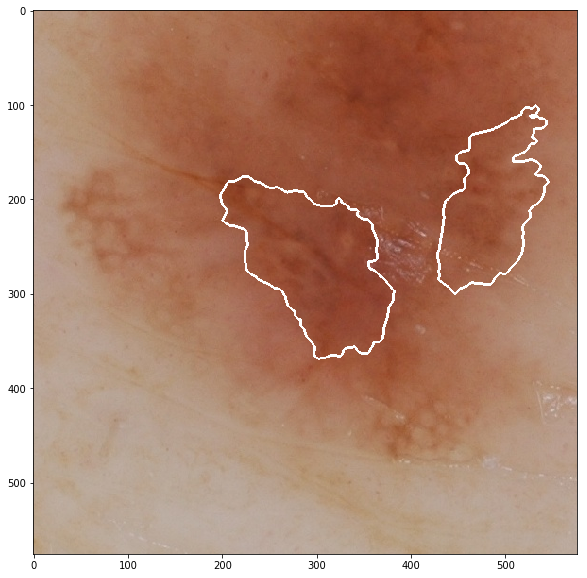

In [151]:
import scipy.ndimage

n = list(ass.__iter__())
# n = list(bss.__iter__())

data = train_dataset[n[6]]
plt.figure(figsize=(10, 10))
mask = data['masks'].numpy()[2]
mask = (np.bitwise_not(mask) & scipy.ndimage.binary_dilation(mask, iterations=3))
plt.imshow(np.expand_dims(mask, -1) + np.rollaxis(data['images'].numpy(), 0, 3)[..., ::-1] * STD[::-1] + MEAN[::-1])
plt.show()
# plt.figure(figsize=(10, 10))
# plt.imshow(data['masks'].numpy()[1])#.sum(0))
# plt.imshow(scipy.ndimage.distance_transform_edt(data['masks'].numpy()[1]))#.sum(0))

In [14]:
import itertools

sigmas = np.arange(0, 2, 1)
compactnesses = np.arange(1, 10)
n_segments = np.arange(26, 45, 2)

configs_ = itertools.product(sigmas, compactnesses, n_segments)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


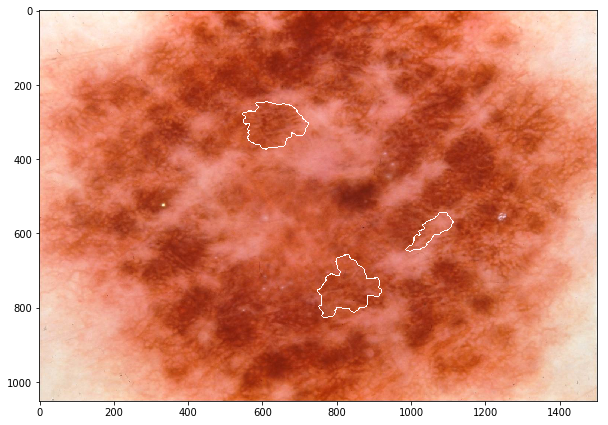

In [119]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import scipy.ndimage

# image = cv2.imread('../data/cropped/JPG/ISIC_0014337_0.jpg')[..., ::-1] / 255.
# mask = cv2.imread('../data/cropped/PNG/ISIC_0014337_attribute_milia_like_cyst_0.png', 0) > 0
image = cv2.imread('../data/ISIC2018_Task1-2_Training_Input/ISIC_0000203.jpg')[..., ::-1] / 255.
mask = cv2.imread('../data/ISIC2018_Task1-2_Training_Input/ISIC_0000203_attribute_negative_network.png', 0) > 0
mask_ = (np.bitwise_not(mask) & scipy.ndimage.binary_dilation(mask, iterations=3))
# image = np.rollaxis(data['images'].numpy(), 0, 3)[..., ::-1] * STD[::-1] + MEAN[::-1]

# loop over the number of segments
configs = []
best_iou = 0
# for i, (sigma, compactness, n_segment) in tqdm(enumerate(configs_)):
n_segment = 189
compactness = 10
sigma = 0

# segments = slic(image, convert2lab=True, n_segments=n_segment, max_iter=10, compactness=compactness, sigma=sigma)
# segments_ = np.stack([(segments == colour) for colour in range(segments.max())])
# colours = np.array([
#     (mask & segment).sum() / (segment).sum()
#     for segment in segments_
# ]) > .5
# segments_ = segments_[np.where(colours)].sum(0) > 0
# iou = (segments_ * mask).sum() / (mask | segments_).sum()
# configs.append({
#     'iou': iou,
#     'compactness': compactness,
#     'sigma': sigma,
#     'n_segment': n_segment
# })
# if iou > best_iou:
clear_output(wait=True)
# best_iou = iou
# best_conf = configs[-1]
# print(best_iou, configs[-1])
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
# ax.imshow(mark_boundaries(image, segments) + np.expand_dims(mask_, -1))
ax.imshow(image + np.expand_dims(mask_, -1))
plt.show()


In [152]:
# define an objective function
def objective(args):
    case, val = args
    if case == 'case 1':
        return val
    else:
        return val ** 2

# define a search space
from hyperopt import hp
space = {
    'n_segments': 100, 
    'compactness': 10.0, 
    'max_iter': 10, 
    'sigma': 0, 
    'spacing': None, 
    'multichannel': True, 
    'convert2lab': None, 
    'enforce_connectivity': True, 
    'min_size_factor': 0.5, 
    'max_size_factor': 3, 
    'slic_zero': hp.uniform('sz', [False, True])
    }
# minimize the objective over the space
from hyperopt import fmin, tpe
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# -> {'a': 1, 'c2': 0.01420615366247227}
# print hyperopt.space_eval(space, best)

In [166]:
path = 'attributes_checkpoints/fpn_dpn92/fold_{}_checkpoint.epoch_loss'
folds = [0, 2, 3]
dicts = [pickle.load(open(path.format(i), 'rb')) for i in folds]
np.array([[v['full_attr'] for v in d['val_iou']] for d in dicts]).shape

(3,)

In [78]:
attributes_areas = {}
for step, (key, el) in tqdm(enumerate(train_dataset.paths.items())):
    areas = np.zeros(shape=(6, el['amount']))
    for i, attr in enumerate(el['attributes']):
        for idx in range(el['amount']):
            mask = cv2.imread(attr.format(idx), 0)
            areas[i, idx] = (mask > 120).sum()
    attributes_areas[key] = np.nan_to_num(areas / np.expand_dims(areas.sum(1), -1))

0it [00:00, ?it/s]/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
2594it [12:35,  3.43it/s]


In [38]:
# pickle.dump(attributes_areas, open('../data/attribute_areas.pkl', 'wb'))

In [12]:
# data = train_dataset[n[9]]
key = 3
el = train_dataset.paths[key]

data = train_dataset[(key, 8)]

areas = np.zeros(shape=(6, el['amount']))
for i, attr in enumerate(el['attributes']):
    for idx in range(el['amount']):
        mask = cv2.imread(attr.format(idx), 0)
        areas[i, idx] = (mask > 120).sum()

plt.imshow(areas / np.expand_dims(areas.sum(1) + 1, -1))
plt.show()

plt.imshow(np.rollaxis(data['images'].numpy(), 0, 3)[..., ::-1] * STD[::-1] + MEAN[::-1])
plt.show()
plt.imshow(data['masks'].numpy()[1])#.sum(0))

KeyError: 'amount'

In [12]:
el = train_dataset.crop_attributes('../data/cropped_full/')

In [19]:
masks = dict()
areas = dict()
for data in tqdm(train_dataset):
    m = data['masks'].numpy()
    masks[data['key']] = { k.split('_')[2]: m[v].sum() for v, k in enumerate(attributes) }
    masks[data['key']]['shape'] = m.shape[1:]
    fm = m[:-1].sum(axis=0)

    if fm.sum():
        coords = np.array(np.where(fm)).T
    else:
        coords = np.array(np.where(m[-1])).T

    areas[data['key']] = np.random.choice(np.arange(len(coords)), replace=False, size=int(np.sqrt(len(coords))))
    areas[data['key']] = coords[areas[data['key']]]
        

100%|██████████| 2594/2594 [07:00<00:00,  6.16it/s]


In [24]:
keys = sorted(list(masks.keys()))

persentage = np.array([
    [
        masks[key][k.split('_')[2]] / (255 * masks[key]['shape'][0] * masks[key]['shape'][0]) 
        for k in attributes
    ] for key in keys])
appearence = np.array([
    [
        masks[key][k.split('_')[2]] > 0 
        for k in attributes
    ] for key in keys])
appearence[:, -1] = np.logical_not(appearence[:, :-1].sum(axis=-1))

In [26]:
appearence_keys = [[keys[idx] for idx in np.where(appearence[..., i])[0]] for i, attr in enumerate(attributes)]
# pickle.dump(appearence_keys, open('../data/attr_appearence_keys', 'wb'))
# pickle.dump(areas, open('../data/attr_areas_dict', 'wb'))
appearence.mean(axis=0)

array([0.23245952, 0.26291442, 0.07324595, 0.58712413, 0.0385505 ,
       0.19814958])

In [122]:
train_datagen = torch.utils.data.DataLoader(train_dataset, batch_size=14, sampler=EqualizedSampler(train_dataset), num_workers=8)

In [123]:
mean = np.zeros((3, ))
std = np.zeros((3, ))

for data in tqdm(train_datagen):
    mean += data['images'].numpy().mean((0, 2, 3))
    std += data['images'].numpy().std((2, 3)).mean(axis=0)

100%|██████████| 186/186 [00:53<00:00,  3.45it/s]


(-0.5, 511.5, 511.5, -0.5)

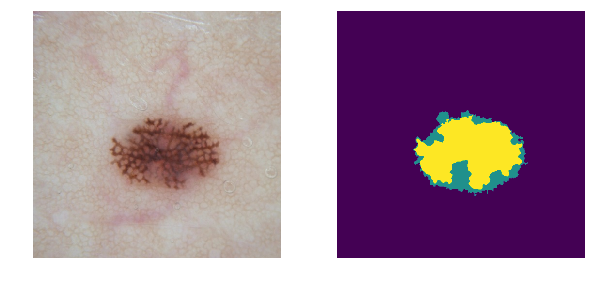

In [126]:
i = 0
plt.figure(figsize=(10, 10))
plt.subplot(221)
plt.imshow((np.rollaxis(data['images'].numpy()[i], 0, 3) * STD + MEAN))
plt.axis('off')
plt.subplot(222)
plt.imshow(data['masks'].numpy()[i].sum(axis=0))
plt.axis('off')

(array([ 514.,    0., 1257.,    0.,    0.,  635.,    0.,  181.,    0.,
           7.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

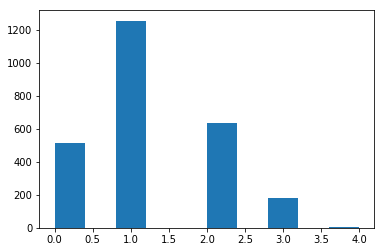

In [202]:
plt.hist(appearence.sum(axis=1))

# Classification Task

In [19]:
import pandas as pd
from glob import glob
import cv2
import os
from tqdm import tqdm
import numpy as np

In [31]:
df = pd.read_csv('../data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv')
appearence = [int(i) for i in df.sum(0).values[1:]]

In [23]:
shapes = list()
means = list()
std = list()

for path in tqdm(glob('../data/ISIC2018_Task3_Training_Input/*.jpg')):
    name = os.path.basename(path).split('.')[0]
    im = cv2.imread(path)
    means.append(np.mean(im.reshape(-1, 3) / 255., axis=(0)))
    std.append(np.std(im.reshape(-1, 3) / 255., axis=(0)))
    if im.shape != (450, 600, 3):
        shapes.append(im.shape)

100%|██████████| 10015/10015 [03:53<00:00, 42.86it/s]


'../data/ISIC2018_Task3_Training_Input/ISIC_0026535.jpg'

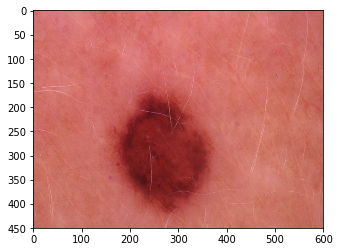

In [5]:
plt.imshow(im[..., ::-1])
path

In [90]:
import pickle 
import os
from glob import glob
import cv2
import numpy as np
import joblib

import torch
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import Sampler
from torchvision.transforms import ToTensor, Normalize, Compose



MEAN = [0.57053024, 0.54612805, 0.76352107]
STD = [0.09505704, 0.0857232 , 0.09826472]

img_transform = Compose([
    ToTensor(),
    Normalize(mean=[0.57053024, 0.54612805, 0.76352107], std=[0.09505704, 0.0857232 , 0.09826472])
])

APPEARENCE = [1113, 6705, 514, 327, 1099, 115, 142]
ATTRIBUTES = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']

INIT_APPEARENCE = [1.] * 7


class ISIC_Dataset(Dataset):
    def __init__(self, root, df, augmentator=None, aug_params={},
                 amounts=None, appearence_mean=INIT_APPEARENCE, 
                 is_test=False, part=0, partsamount=1, exclude=False, seed=None):
        self.augmentator = augmentator
        self.aug_params = aug_params
        self.augmentations = augmentator(**self.aug_params)

        self.is_test = is_test
        self.paths = {}
        
        template=os.path.join(root, '*.jpg')
        paths = sorted(glob(template))

        if seed is not None:
            rs = np.random.RandomState(seed=seed)
            rs.shuffle(paths)

        step = len(paths) // partsamount

        if exclude:
            paths = paths[:part * step] + paths[(part + 1) * step:]
        else:
            paths = paths[part * step : (part + 1) * step]

        for path in tqdm(paths):
            key = os.path.basename(path).split('.')[0]
            self.paths[key] = {
                'image': path,
                'class': df.query('image==@name').values[0, 1:].astype(np.float)
            }

        self.keys = list(self.paths.keys())
        self.appearence_mean = appearence_mean

    def aug_strength_decay(self, decay=1.):
        self.aug_params['strength'] *= decay
        self.augmentations = self.augmentator(**self.aug_params)

    def converge_appearence(self, decay=1.):
        self.appearence_mean = [
            (1 - decay) * sa + decay * ga 
            for sa, ga in zip(self.appearence_mean, APPEARENCE)
        ]

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        key = self.keys[idx]
        img = cv2.imread(self.paths[key]['image'])
        if self.augmentations is not None:
            img, _ = self.augmentations(img, is_test=self.is_test)
        return {
            'key': key,
            'images': img_transform(img), 
            'class': torch.from_numpy(self.paths[key]['class'])
        }


class EqualizedSampler(Sampler):
    r"""Samples elements randomly, without replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, df):
        self.data_source = data_source
        self.keys = data_source.keys
        keys = self.keys.copy()
        self.df = df.query('image==@keys')
        self.attributes_keys = [
            self.df.query('{}==1'.format(attr)).image.values 
            for attr_id, attr in enumerate(ATTRIBUTES)
        ]

    def __iter__(self):
        keys = list()
        self.recompute_probs()
        for i in range(len(self.data_source)):
            attr_id = np.random.choice(np.arange(len(self.probs)), p=self.probs)
            key = np.random.choice(self.attributes_keys[attr_id])
            keys.append((key))

        return iter(keys)

    def __len__(self):
        return len(self.data_source)

    def recompute_probs(self):
        print('appearence recomputed')
        self.probs = np.array(self.data_source.appearence_mean)
        #self.probs = np.array(self.probs) ** .3
        self.probs /= self.probs.sum()
        print(self.probs)


class ValSampler(Sampler):
    r"""Samples elements randomly, without replacement.

    Arguments:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self, data_source, df):
        self.data_source = data_source
        self.keys = data_source.keys
        keys = self.keys.copy()
        self.df = df.query('image==@keys')

    def __iter__(self):
        return iter(self.keys)

    def __len__(self):
        return len(self.data_source)


In [75]:
dataset = ISIC_Dataset(
    '../data/ISIC2018_Task3_Training_Input', 
    df, 
    Augmentation, 
    aug_params={'strength': 1., 'side': 448}
)

100%|██████████| 10015/10015 [00:12<00:00, 794.98it/s]


In [85]:
dg = EqualizedSampler(dataset, df)

In [86]:
for data in dg:
    break

appearence recomputed
[0.14285714 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714
 0.14285714]


0

In [94]:
dataset[0]['class']

tensor([ 1.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=torch.float64)